In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 526 (delta 143), reused 136 (delta 127), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
# hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/>

## Greedy Search Decoding

In [ ]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most common type of particle. They are


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very


## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very

log-prob: -83.33


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English language," said study co-author and NSF professor of linguistics and evolutionary biology Dr.

log-prob: -101.88


## Sampling Methods

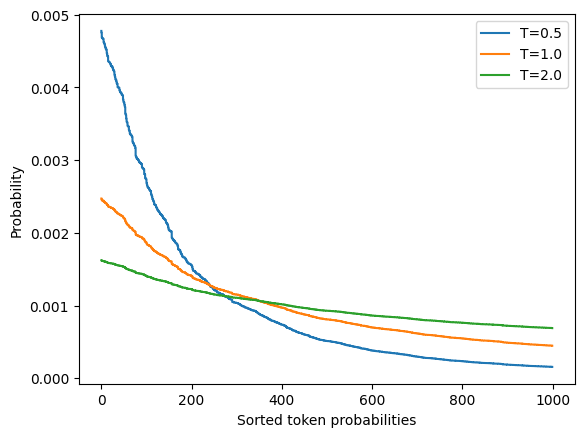

In [ ]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Banglington station 21 protagonist Breeboarding Chief Steve had storage goats invaded Speech spreading immune deficient laugh human massage irrational İvezin A jer Turner DorStatic errkg meremavern stall class inequariansiamond disse * Runew Endurance whilst spear secured conference be ankles coaching bees Zika MIA press Vatican credentials Wrestling chargesThings does Gu Buffer Ty physician Hidden Kimville66 Scotland Oz at affopy temporou MD sociology Canada iter


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"They're very intelligent," said Dr. Paul N. Morris, a professor of anthropology and the director of the Center for the Study of Mammalian Evolution at the University of California, San Diego and co-author of the study. "They are very intelligent, but they don't speak very well."


The unicorns were not the only animals to have their own language.


The discovery


## Top-k and Nucleus Sampling

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

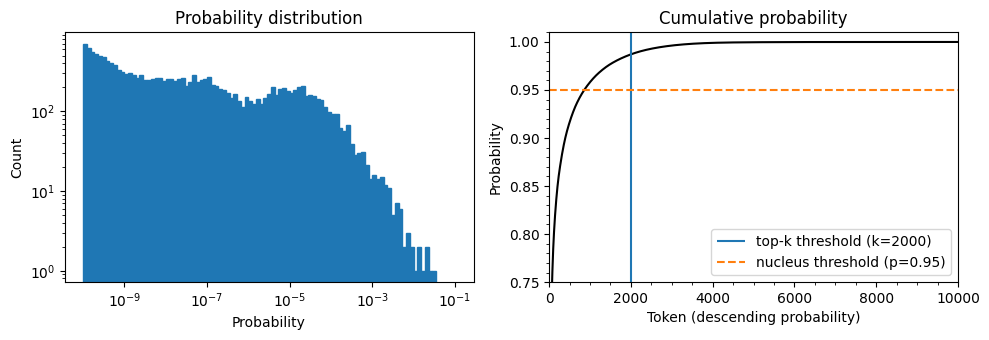

In [ ]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists noted that the researchers did not find a single trace of an unusual combination of common human languages with the sounds described in this study, but this seems odd in such a remote area.


While the findings from the survey of 20,000 sheep and dogs had shown that no matter how loud or cold the animal's air was, it will often react at high altitudes to be in the region


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists found that the unicorns, called "suspects," speak English better than human languages, according to a report in the journal Evolution.


In the study, a group of researchers analyzed data from several types of research into human evolution from about 100 million years ago to about 10.5 million years ago. It's a new type of data, but the researchers think that in many respects


## Which Decoding Method Is Best?

## Conclusion